# objectives - model different scenarios for schools and observe predicted changed in student scores 

- load model
- retrain model 
- select schools to model 
- generate alternative key feature values to model 
- observe adjusted score predictions 

In [1]:

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Load Random Forest Model

In [2]:
expected_model_version = '1.0'
model_path = '../../models/11th_grade_scoring_model.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

In [3]:
model.version

'1.0'

In [4]:
df = pd.read_csv('../../data/model/XY_final.csv')
df.drop('Unnamed: 0',inplace=True,axis=1)
labels = df[['County_Name', 'District_Name', 'School_Name']].copy()
df.shape

(52665, 63)

In [5]:
X = df[model.X_columns]
print(X.shape)
y = df['Mean Scale Score']
print(y.shape)

(52665, 59)
(52665,)


# Train on all data 

In [6]:
model.fit(X,y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=77))])

In [27]:
# import sklearn.metrics
# sklearn.metrics.SCORERS.keys()

# check scores of model 

In [84]:
results = cross_validate(model, X, y ,cv=5)
scores = results['test_score']
np.mean(scores), np.std(scores)

(0.5589975643193457, 0.10309691443116767)

# confirm feature importance 

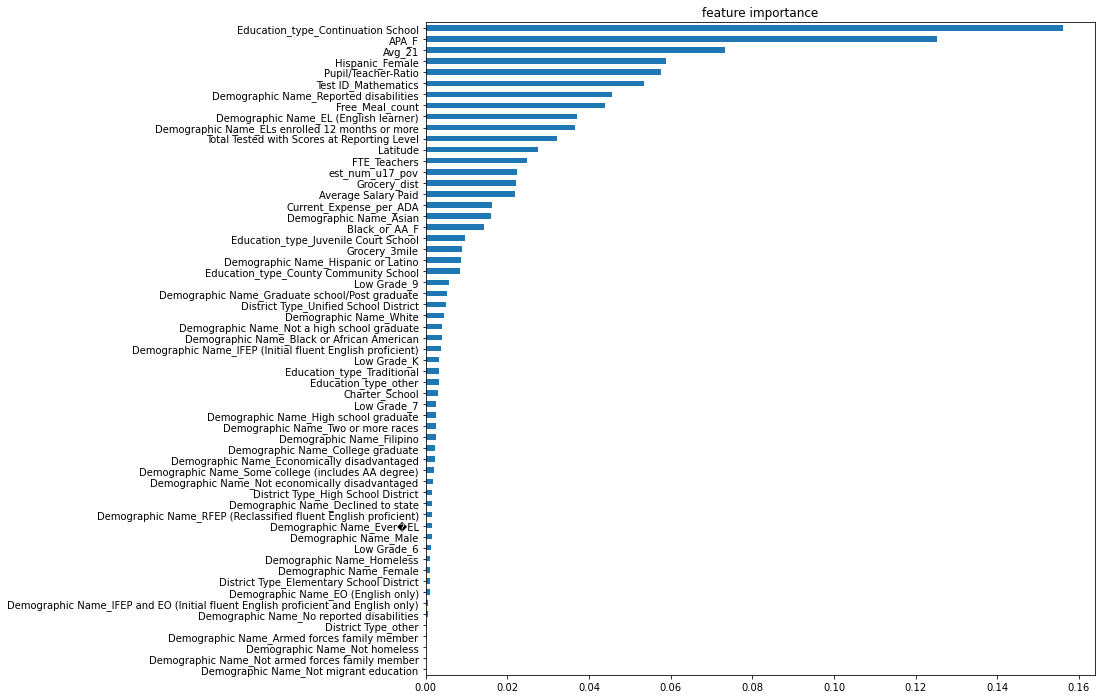

In [92]:
names = zip(model.X_columns,model.named_steps.randomforestregressor.feature_importances_)
names
fig, ax = plt.subplots(figsize=(12,12))
imps = model.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=model.X_columns).sort_values()
plt.title('feature importance')
fig = rf_feat_imps.plot(kind='barh')
plt.show()

#  Function to predict score change 

In [97]:
def predict_change( model,df,school,demographic,features, deltas):
    """Isolate row of df and predict change in scores due to feature change"""
    school=df[df['School_Name'].str.startswith(school)]
    group = 'Demographic Name_'+demographic
    row = school[school[group]==1]
    row = row.drop(['Mean Scale Score', 'County_Name','District_Name', 'School_Name'],axis=1)
 
    adj_school = row.copy()
    adj_school = adj_school

    for f,d in zip(features, deltas):
        adj_school[f] += d

    return model.predict(adj_school).item() - model.predict(row).item()

In [68]:
model.X_columns[:5]

['Total Tested with Scores at Reporting Level',
 'Charter_School',
 'Free_Meal_count',
 'Latitude',
 'FTE_Teachers']

In [99]:
teacher_delta = [i for i in range(5,50,5)]


In [100]:

score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['FTE_Teachers'],[delta]) for delta in teacher_delta]
score_deltas

[-2.3753246753249186,
 -4.814285714286143,
 -5.848051948052216,
 -7.151948051948239,
 -10.34025974026008,
 -10.34025974026008,
 -10.34025974026008,
 -10.34025974026008,
 -10.34025974026008]

In [101]:
teacher_neg = [i for i in range(-5,-50,-5)]
teacher_neg

[-5, -10, -15, -20, -25, -30, -35, -40, -45]

In [102]:

score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['FTE_Teachers'],[delta]) for delta in teacher_neg]
score_deltas

[-1.423376623376953,
 -1.5883116883119328,
 -0.5935064935069931,
 -4.727272727272975,
 -6.72597402597421,
 -12.312987012987378,
 -12.312987012987378,
 -12.312987012987378,
 -12.312987012987378]

In [104]:
housing_neg = [i for i in range(-10000,-1000000,-100000)]
housing_neg

[-10000,
 -110000,
 -210000,
 -310000,
 -410000,
 -510000,
 -610000,
 -710000,
 -810000,
 -910000]

In [105]:
# negative 
score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['Avg_21'],[delta]) for delta in housing_neg]
score_deltas

[0.0,
 1.3155844155839986,
 1.455844155844261,
 1.5857142857144026,
 0.2961038961034319,
 -14.698701298701508,
 -24.161038961039594,
 -26.788311688312206,
 -25.68051948052016,
 -26.250649350650292]

In [106]:
# positive 
housing_delta = [i for i in range(10000,1000000,100000)]

score_deltas = [predict_change(model,df,
                            'Oceana','Filipino',
                            ['Avg_21'],[delta]) for delta in housing_delta]
score_deltas

[0.0,
 0.16103896103868465,
 23.13896103895877,
 27.724675324672717,
 28.393506493503992,
 26.124675324673717,
 24.970129870128403,
 24.970129870128403,
 24.94675324675154,
 25.80259740259544]

## Refit model with all data 


plot compare key features to be adjusted 

use predict increase to generate alternative scores due to change in model features 

graph changes in scores due to adjusted features 



In [44]:
labels.columns

Index(['County_Name', 'District_Name', 'School_Name'], dtype='object')

In [53]:
df[df['District_Name'].str.startswith('San')]['District_Name'].unique()

array(['San Ramon Valley Unified', 'Sanger Unified', 'San Marino Unified',
       'Santa Monica-Malibu Unified', 'San Gabriel Unified',
       'San Rafael City High', 'Santa Ana Unified', 'San Jacinto Unified',
       'San Jacinto Valley Academy', 'San Juan Unified',
       'San Benito High', 'San Bernardino County Office of Educatio',
       'San Bernardino City Unified',
       'San Diego County Office of Education',
       'San Diego Workforce Innovation High', 'San Diego Virtual',
       'San Diego Unified', 'San Dieguito Union High',
       'San Diego Mission Academy',
       'San Joaquin County Office of Education',
       'San Luis Obispo County Office of Educati',
       'San Luis Coastal Unified',
       'Santa Clara County Office of Education', 'San Jose Unified',
       'Santa Clara Unified', 'San Lorenzo Valley Unified',
       'Santa Cruz City High'], dtype=object)

In [54]:
df[df['District_Name'].str.startswith('Jef')]['District_Name'].unique()

array(['Jefferson Union High'], dtype=object)

In [58]:
df[df['County_Name'].str.startswith('San Mateo')]['School_Name'].unique()

array(['Oxford Day Academy', 'California Virtual Academy San Mateo',
       'Jefferson High', 'Oceana High', 'Terra Nova High',
       'Westmoor High', 'Baden High (Continuation)', 'El Camino High',
       'South San Francisco High'], dtype=object)

In [81]:
df[(df['District_Name'].str.startswith('Jef'))
   &(df['Demographic Name_Filipino']==1)]

,Total Tested with Scores at Reporting Level,Charter_School,Free_Meal_count,Latitude,FTE_Teachers,Pupil/Teacher-Ratio,Hispanic_Female,Black_or_AA_F,APA_F,Avg_21,...,District Type_other,Education_type_Continuation School,Education_type_County Community School,Education_type_Juvenile Court School,Education_type_Traditional,Education_type_other,Mean Scale Score,County_Name,District_Name,School_Name
42616,78.0,0,407.0,37.6961,61.06,21.70,260.0,9.0,250.0,1086472.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2623.0,San Mateo,Jefferson Union High,Jefferson High
42631,21.0,0,407.0,37.6961,61.06,21.70,260.0,9.0,250.0,1086472.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2616.4,San Mateo,Jefferson Union High,Jefferson High
42634,57.0,0,407.0,37.6961,61.06,21.70,260.0,9.0,250.0,1086472.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2625.4,San Mateo,Jefferson Union High,Jefferson High
42647,66.0,0,407.0,37.6961,61.06,21.70,260.0,9.0,250.0,1086472.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2589.5,San Mateo,Jefferson Union High,Jefferson High
42660,17.0,0,407.0,37.6961,61.06,21.70,260.0,9.0,250.0,1086472.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2596.2,San Mateo,Jefferson Union High,Jefferson High
42663,49.0,0,407.0,37.6961,61.06,21.70,260.0,9.0,250.0,1086472.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2587.2,San Mateo,Jefferson Union High,Jefferson High
42673,11.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2625.6,San Mateo,Jefferson Union High,Oceana High
42730,90.0,0,367.0,37.6832,63.66,21.93,162.0,3.0,414.0,1224926.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2651.9,San Mateo,Jefferson Union High,Westmoor High
42744,15.0,0,367.0,37.6832,63.66,21.93,162.0,3.0,414.0,1224926.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2583.2,San Mateo,Jefferson Union High,Westmoor High
42747,75.0,0,367.0,37.6832,63.66,21.93,162.0,3.0,414.0,1224926.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2665.6,San Mateo,Jefferson Union High,Westmoor High


In [61]:
# df['District_Name'].unique()

In [12]:
oceana = df[df['School_Name'].str.startswith('Oceana')]
oceana

,Total Tested with Scores at Reporting Level,Charter_School,Free_Meal_count,Latitude,FTE_Teachers,Pupil/Teacher-Ratio,Hispanic_Female,Black_or_AA_F,APA_F,Avg_21,...,District Type_other,Education_type_Continuation School,Education_type_County Community School,Education_type_Juvenile Court School,Education_type_Traditional,Education_type_other,Mean Scale Score,County_Name,District_Name,School_Name
42665,50.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2671.3,San Mateo,Jefferson Union High,Oceana High
42666,29.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2691.4,San Mateo,Jefferson Union High,Oceana High
42667,21.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2643.6,San Mateo,Jefferson Union High,Oceana High
42668,46.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2687.4,San Mateo,Jefferson Union High,Oceana High
42669,50.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2671.3,San Mateo,Jefferson Union High,Oceana High
42670,11.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2663.3,San Mateo,Jefferson Union High,Oceana High
42671,50.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2671.3,San Mateo,Jefferson Union High,Oceana High
42672,50.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2671.3,San Mateo,Jefferson Union High,Oceana High
42673,11.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2625.6,San Mateo,Jefferson Union High,Oceana High
42674,11.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2713.0,San Mateo,Jefferson Union High,Oceana High


In [95]:
oceana[oceana['Demographic Name_Filipino']==1][:20]

,Total Tested with Scores at Reporting Level,Charter_School,Free_Meal_count,Latitude,FTE_Teachers,Pupil/Teacher-Ratio,Hispanic_Female,Black_or_AA_F,APA_F,Avg_21,...,District Type_other,Education_type_Continuation School,Education_type_County Community School,Education_type_Juvenile Court School,Education_type_Traditional,Education_type_other,Mean Scale Score,County_Name,District_Name,School_Name
42673,11.0,0,113.0,37.6387,31.65,18.83,71.0,1.0,98.0,1274587.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2625.6,San Mateo,Jefferson Union High,Oceana High


In [13]:
type(oceana[oceana['Demographic Name_Filipino']==1])

pandas.core.frame.DataFrame

In [110]:
oceana[oceana['Demographic Name_Filipino']==1].loc[:,'Total Tested with Scores at Reporting Level':'Mean Scale Score'].T

,42673
Total Tested with Scores at Reporting Level,1.100000e+01
Charter_School,0.000000e+00
Free_Meal_count,1.130000e+02
Latitude,3.763870e+01
FTE_Teachers,3.165000e+01
Pupil/Teacher-Ratio,1.883000e+01
Hispanic_Female,7.100000e+01
Black_or_AA_F,1.000000e+00
APA_F,9.800000e+01
Avg_21,1.274587e+06
